In [1]:
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pylab as plt
import math
from pathlib import Path # Python >= 3.5, for folder creation
import random # Random seed
from tqdm import tqdm # Progress bar in for loop

# Tensorflow
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
# from keras.layers import Dense, Flatten, Conv2D
# # from tensorflow.keras import Model
from keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical
from scipy.interpolate import NearestNDInterpolator

Using TensorFlow backend.


# Part 1: Data Preprocessing

In [2]:
# Input: Stationary and nonstationary generated data
#          Stationary files are located in directory_in_str_locs_stationary (locations) 
#          and directory_in_str_z_stationary (observed values)
# 
#          File names: LOC_3600_sample_1.txt, LOC_3600_sample_2.txt, ... (locations)
#                      Z_3600_sample_1.txt, Z_3600_sample_2.txt, ... (observed values)
# 
#          Format examples: 
#          LOC_3600_sample_1.txt:         Z_3600_sample_1.txt
#          0.012863,0.006928              1.264426
#          0.019715,0.003342              -0.526158
#          ...                            ...
# 
#          step_size: Step for jumping the plot. 
#                     When step_size = 10, the notebook plots preprocessed data for number 0, 10, 20, ...
# 
# Output: npz files containing preprocessed data inside save_data_string
#         plots of the preprocessed data inside save_fig_string

# Inputs

In [3]:
# Folder places and filenames
# Stationary
directory_in_str_locs_stationary = "D:/Research2021-C/Pratik项目/0511Pratik_Data/stationary_data/"
directory_in_str_z_stationary = "D:/Research2021-C/Pratik项目/0511Pratik_Data/stationary_data/"
locs_string_stationary = "LOC_20000_univariate_matern_stationary_" # LOC_3600_sample_1.txt, LOC_3600_sample_2.txt, ...
z_string_stationary = "Z1_20000_univariate_matern_stationary_" # Z_3600_sample_1.txt, Z_3600_sample_2.txt, ...
# Nonstationary
directory_in_str_locs_nonstationary = "D:/Research2021-C/Pratik项目/0511Pratik_Data/nonstationary_data/"
directory_in_str_z_nonstationary = "D:/Research2021-C/Pratik项目/0511Pratik_Data/nonstationary_data/"
locs_string_nonstationary = "LOC_20000_univariate_matern_non_stat_estimation_"
z_string_nonstationary = "Z1_20000_univariate_matern_non_stat_estimation_"

In [4]:
# Saving places
save_data_string = "D:/Research2021-C/Pratik项目/0511Processed_Data/"
save_fig_string = "D:/Research2021-C/Pratik项目/0511Processed_Data/Plots/"

In [5]:
# Saving names for the npz
npzfilename_stationary = "Dat_stationary_0511Pratik.npz";
npzfilename_nonstationary = "Dat_nonstationary_0511Pratik.npz";

In [6]:
# Step for jumping the plot. step_size=10: plot number 0, 10, 20, and so on. 
step_size = 100; # Step for jumping the plot. step_size=10: plot number 0, 10, 20, and so on. 

In [7]:
# Valid for both stationary and nonstationary data. 
# If the range of locations are determined manually
manual_range_locs = False
# If the range of observations are determined manually
manual_range_z = False

In [8]:
# Range of locations when manual_range_locs = True
if manual_range_locs == True:
    startx = 0
    endx = 1
    starty = 0
    endy = 1

In [9]:
# Range of observations when manual_range_z = True
if manual_range_z == True:
    m = 0
    M = 1 # The range of observations is [m, M]. 

In [10]:
# Places for location saving
model_saving_location = 'D:/Research2021-C/Pratik项目/0511Processed_Data/Model/Model_Example'

# Statioanry data preprocessing

In [11]:
# Initialization 
directory_in_str_locs = directory_in_str_locs_stationary
directory_in_str_z = directory_in_str_z_stationary
locs_string = locs_string_stationary
z_string = z_string_stationary

In [12]:
directory_locs = os.fsencode(directory_in_str_locs)
data_files_locs = os.listdir(directory_locs)

In [13]:
# list of filename
loc_files = [f for f in os.listdir(directory_in_str_locs_stationary) if f.startswith(locs_string_stationary)]

In [14]:
# Grid row and column
GRID_ROWS = 100
GRID_COLS = 100

# Initialization continued
ndata = len(loc_files)
#ndata = 100 # Test
stationary_x_train = np.zeros((ndata,GRID_COLS,GRID_ROWS))

stationary_y_train = np.zeros(ndata) # Zero = the model is stationary. One = nonstationary. 

In [15]:
# Initialization continued
param_val_is_stat = 1;
npzfilename = npzfilename_stationary;

In [16]:
# Initialization continued
param_is_stat = np.ones(ndata)
#param_samplenum.fill(param_val_samplenum)
param_is_stat.fill(param_val_is_stat)

param_list = []

In [17]:
ndata

1462

In [18]:
# Main program for data preprocessing
for i in tqdm(range(ndata)):
    # Append the parameter to samples. 
    param_dict = {
        "sample": i,
        "is_stat": param_val_is_stat
    }
    param_list.append(param_dict)
    #==========
    # Data extraction
    #===========
    # Get location and observation files for each subsample
    loc_text = loc_files[i]
    z_text = loc_text.replace(locs_string, z_string, 1)
    # Load the location and z files
    location_file = open(directory_in_str_locs + loc_text)
    Z_value_file = open(directory_in_str_z + z_text)
#     print(location_file)
    locations = np.loadtxt(location_file, delimiter=',')
    Z_values = np.loadtxt(Z_value_file, delimiter=',')
    #==========
    # End of data extraction
    #==========
    # Compute the output grid
    output_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_sum_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_div_arr = np.zeros((GRID_ROWS,GRID_COLS))
    if manual_range_locs == False:
        # Start and end locations (Auto)
#         print(locations[:,0],locations[:,1])
        startx = min(locations[:, 0])
        starty = min(locations[:, 1])
        endx = max(locations[:, 0])
        endy = max(locations[:, 1])
#     print(locations)
    locations[:,0] = (locations[:, 0] - startx)/(endx - startx)
    locations[:,1] = (locations[:, 1] - starty)/(endy - starty)
#     print(locations)
    
    X = np.linspace(0, 1,GRID_COLS)
    Y = np.linspace(0, 1,GRID_ROWS)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = NearestNDInterpolator(locations, Z_values)
    Z = interp(X, Y)
#     break
#     # Get the summation and division
#     for j in range(locations.shape[0]):
#         # Get the grid locations (x, y). Result: [y][x], because x is column (x=0 is the first column). 
#         x = int(math.floor((locations[j][0] - startx) * GRID_COLS / (endx - startx)))
#         y = int(math.floor((locations[j][1] - starty) * GRID_ROWS / (endy - starty)))
#         # For boundary value problems
#         x = min(x, GRID_COLS - 1)
#         y = min(y, GRID_ROWS - 1)
#         val = Z_values[j]
#         # Add the summation and division
#         grid_sum_arr[y][x] = grid_sum_arr[y][x] + val
#         grid_div_arr[y][x] += 1
#     # Generate output
#     for j1 in range(GRID_ROWS):
#         for j2 in range(GRID_COLS):
#             if grid_div_arr[j1][j2] > 0:
#                 # Mean value in a cell
#                 output_arr[j1][j2] += (grid_sum_arr[j1][j2] / grid_div_arr[j1][j2])
#             else:
#                 # Mean value over all regions if the cell has no locations
#                 output_arr[j1][j2] += np.mean(Z_values)
    if manual_range_z == False:
        # Normalize (Auto)
        m = np.min(Z)
        M = np.max(Z)
    if m == M:
        Z = np.ones((GRID_ROWS,GRID_COLS)) * 0.5 # All 0.5
    else: 
        # Range from 0 to 1. 
        Z = (Z - m) / (M - m)
    # Save results
    stationary_x_train[i] = Z

100%|██████████| 1462/1462 [04:45<00:00,  5.12it/s]


In [19]:
# Save to file
nparams = np.array(param_list)
Path(save_data_string).mkdir(parents=True, exist_ok=True)
np.savez( save_data_string + npzfilename, x = stationary_x_train, y = stationary_y_train, params = nparams)

In [20]:
Path(save_fig_string).mkdir(parents=True, exist_ok=True)
for i in tqdm(range(0 , len(loc_files) , int(step_size))):
#for i in tqdm(range(0, 100, int(step_size))): 
    plt.figure()
    ax = sns.heatmap( stationary_x_train[i] , linewidth=0)
    plt.savefig(save_fig_string + npzfilename + loc_files[i] +".png")
    plt.close()

100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


<AxesSubplot:>

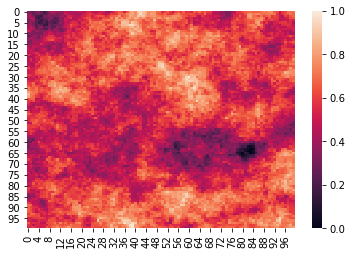

In [21]:
sns.heatmap( stationary_x_train[2] , linewidth=0)

# Nonstationary data preprocessing

In [18]:
# Initialization 
directory_in_str_locs = directory_in_str_locs_nonstationary
directory_in_str_z = directory_in_str_z_nonstationary
locs_string = locs_string_nonstationary
z_string = z_string_nonstationary

In [19]:
directory_locs = os.fsencode(directory_in_str_locs)
data_files_locs = os.listdir(directory_locs)

In [20]:
# list of filename
loc_files = [f for f in os.listdir(directory_in_str_locs_nonstationary) if f.startswith(locs_string_nonstationary)]

In [21]:
# Grid row and column
GRID_ROWS = 100
GRID_COLS = 100

# Initialization continued
ndata = len(loc_files)
#ndata = 100 # Test
nonstationary_x_train = np.zeros((ndata,GRID_COLS,GRID_ROWS))

nonstationary_y_train = np.ones(ndata) # Zero = the model is stationary. One = nonstationary. 

In [22]:
# Initialization continued
param_is_stat = np.ones(ndata)
#param_samplenum.fill(param_val_samplenum)
param_val_is_stat = 0; # Nonstationary. 
param_is_stat.fill(param_val_is_stat)

param_list = []

In [23]:
# Initialization continued
npzfilename = npzfilename_nonstationary;

In [28]:
# Main program for data preprocessing
for i in tqdm(range(ndata)):
    # Append the parameter to samples. 
    param_dict = {
        "sample": i,
        "is_stat": param_val_is_stat
    }
    param_list.append(param_dict)
    #==========
    # Data extraction
    #===========
    # Get paired location and observation files
#     print(loc_files[i])
    loc_text = loc_files[i]
    z_text = loc_text.replace(locs_string, z_string, 1)
    # Load the location and z files
    location_file = open(directory_in_str_locs + loc_text)
    Z_value_file = open(directory_in_str_z + z_text)
    locations = np.loadtxt(location_file, delimiter=',')
    Z_values = np.loadtxt(Z_value_file, delimiter=',')
    #==========
    # End of data extraction
    #==========
    # Check if there is NaN value
    if any(np.isnan(Z_values)) == True:
        print("Warning: NaN values occur in i=", i, "; location file:", loc_text)
        Z_values[np.isnan(Z_values)] = 0
    # Compute the output grid
    output_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_sum_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_div_arr = np.zeros((GRID_ROWS,GRID_COLS))
    if manual_range_locs == False:
        # Start and end locations (Auto)
#         print(locations[:,0],locations[:,1])
        startx = min(locations[:, 0])
        starty = min(locations[:, 1])
        endx = max(locations[:, 0])
        endy = max(locations[:, 1])
#     print(locations)
    locations[:,0] = (locations[:, 0] - startx)/(endx - startx)
    locations[:,1] = (locations[:, 1] - starty)/(endy - starty)
#     print(locations)
    
    X = np.linspace(0, 1,GRID_COLS)
    Y = np.linspace(0, 1,GRID_ROWS)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = NearestNDInterpolator(locations, Z_values)
    Z = interp(X, Y)
#     break
#     # Get the summation and division
#     for j in range(locations.shape[0]):
#         # Get the grid locations (x, y). Result: [y][x], because x is column (x=0 is the first column). 
#         x = int(math.floor((locations[j][0] - startx) * GRID_COLS / (endx - startx)))
#         y = int(math.floor((locations[j][1] - starty) * GRID_ROWS / (endy - starty)))
#         # For boundary value problems
#         x = min(x, GRID_COLS - 1)
#         y = min(y, GRID_ROWS - 1)
#         val = Z_values[j]
#         # Add the summation and division
#         grid_sum_arr[y][x] = grid_sum_arr[y][x] + val
#         grid_div_arr[y][x] += 1
#     # Generate output
#     for j1 in range(GRID_ROWS):
#         for j2 in range(GRID_COLS):
#             if grid_div_arr[j1][j2] > 0:
#                 # Mean value in a cell
#                 output_arr[j1][j2] += (grid_sum_arr[j1][j2] / grid_div_arr[j1][j2])
#             else:
#                 # Mean value over all regions if the cell has no locations
#                 output_arr[j1][j2] += np.mean(Z_values)
    if manual_range_z == False:
        # Normalize (Auto)
        m = np.min(Z)
        M = np.max(Z)
    if m == M:
        Z = np.ones((GRID_ROWS,GRID_COLS)) * 0.5 # All 0.5
    else: 
        # Range from 0 to 1. 
        Z = (Z - m) / (M - m)
    # Save results
    nonstationary_x_train[i] = Z

100%|██████████| 504/504 [01:40<00:00,  5.04it/s]


In [29]:
# Save to file
nparams = np.array(param_list)
Path(save_data_string).mkdir(parents=True, exist_ok=True)
np.savez( save_data_string + npzfilename, x = nonstationary_x_train, y = nonstationary_y_train, params = nparams)

In [30]:
Path(save_fig_string).mkdir(parents=True, exist_ok=True)
for i in tqdm(range(0 , len(loc_files) , int(step_size))):
#for i in tqdm(range(0, 100, int(step_size))): 
    plt.figure()
    ax = sns.heatmap( nonstationary_x_train[i] , linewidth=0)
    plt.savefig(save_fig_string + npzfilename + loc_files[i] +".png")
    plt.close()

100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


# Part 2: CNN Model Training

In [31]:
# Train the CNN model that can determine whether a spatial data is stationary. 
# Input: 
#    Preprocessed data in npz format: stationary_npz_filename (stationary) and nonstationary_npz_filename (nonstationary). 
# 
#    Location for saving the CNN model: model_saving_location. 
# 
#    Split rate: split_size_stationary (stationary) and split_size_nonstationary (nonstationary). 
#                The training data will be split following the split size. 
#                For instance, when split_size_stationary = 0.8, 
#                then 80% stationary data is the training data, and the rest 20% are the test data. 
# 
# Output: 
#    Trained CNN model saved in model_saving_location. 
#    Histogram and outlines for the correct rate of the CNN training model. 

# Inputs

In [24]:
# Filename for preprocessing data (.npz format)
stationary_npz_filename = save_data_string + npzfilename_stationary
nonstationary_npz_filename = save_data_string + npzfilename_nonstationary

In [25]:
# Split rate for stationary data
split_size_stationary = 0.8
# Split rate for nonstationary data
split_size_nonstationary = 0.8

# Loading Data

In [26]:
# Stationary data - load npz file
npzfile = np.load(stationary_npz_filename, allow_pickle=True)
stationary_x_all = npzfile['x'] # Preprocessed data
stationary_y_all = npzfile['y'] # Stationary or nonstationary
stationary_params = npzfile['params']
print(stationary_x_all.shape)

(1462, 100, 100)


In [27]:
# Nonstationary data - load npz file
npzfile = np.load(nonstationary_npz_filename, allow_pickle=True)
tx = npzfile['x']
nonstationary_x_all = npzfile['x'] # Preprocessed data
nonstationary_y_all = npzfile['y'] # Stationary or nonstationary
nonstationary_params = npzfile['params']
print(nonstationary_x_all.shape)

(504, 100, 100)


# Randomising and Splitting Data

In [28]:
# Split for stationary data
total_size_stationary = int(len(stationary_x_all))
training_size_stationary = int(total_size_stationary * split_size_stationary)
test_size_stationary = total_size_stationary - training_size_stationary
print(training_size_stationary)
print(test_size_stationary)

# Split for nonstationary data
total_size_nonstationary = int(len(nonstationary_x_all))
training_size_nonstationary = int(total_size_nonstationary * split_size_nonstationary)
test_size_nonstationary = total_size_nonstationary - training_size_nonstationary
print(training_size_nonstationary)
print(test_size_nonstationary)

1169
293
403
101


In [29]:
# Shuffler for stationary and nonstationary
random.seed(220)
shuffler_stationary = random.sample(range(total_size_stationary), total_size_stationary)
shuffler_nonstationary = random.sample(range(total_size_nonstationary), total_size_nonstationary)

In [30]:
# Shuffle data
stationary_x_shuffled = stationary_x_all[shuffler_stationary, 0:GRID_ROWS, 0:GRID_COLS]
stationary_y_shuffled = stationary_y_all[shuffler_stationary]
stationary_params_shuffled = stationary_params[shuffler_stationary, ]
nonstationary_x_shuffled = nonstationary_x_all[shuffler_nonstationary, 0:GRID_ROWS, 0:GRID_COLS]
nonstationary_y_shuffled = nonstationary_y_all[shuffler_nonstationary]
nonstationary_params_shuffled = nonstationary_params[shuffler_nonstationary, ]

In [31]:
# List of shuffled file names - if someone wants copying files
# Stationary
loc_files = [f for f in os.listdir(directory_in_str_locs_stationary) if f.startswith(locs_string_stationary)]
z_files = [f for f in os.listdir(directory_in_str_z_stationary) if f.startswith(z_string_stationary)]
loc_files_stationary_shuffled = [loc_files[i] for i in shuffler_stationary]
z_files_stationary_shuffled = [z_files[i] for i in shuffler_stationary]
# Nonstationary
loc_files = [f for f in os.listdir(directory_in_str_locs_nonstationary) if f.startswith(locs_string_nonstationary)]
z_files = [f for f in os.listdir(directory_in_str_z_nonstationary) if f.startswith(z_string_nonstationary)]
loc_files_nonstationary_shuffled = [loc_files[i] for i in shuffler_nonstationary]
z_files_nonstationary_shuffled = [z_files[i] for i in shuffler_nonstationary]

In [32]:
# Copying files
#loc_test_stationary_copyfolder = "D:/Research2021-C/Pratik项目/0406Processed_Data/LOCS_Test_Stationary/"
#loc_test_nonstationary_copyfolder = "D:/Research2021-C/Pratik项目/0406Processed_Data/LOCS_Test_Nonstationary/"
#z_test_stationary_copyfolder = "D:/Research2021-C/Pratik项目/0406Processed_Data/Z_Test_Stationary/"
#z_test_nonstationary_copyfolder = "D:/Research2021-C/Pratik项目/0406Processed_Data/Z_Test_Nonstationary/"
#Path(loc_test_stationary_copyfolder).mkdir(parents=True, exist_ok=True)
#Path(loc_test_nonstationary_copyfolder).mkdir(parents=True, exist_ok=True)
#Path(z_test_stationary_copyfolder).mkdir(parents=True, exist_ok=True)
#Path(z_test_nonstationary_copyfolder).mkdir(parents=True, exist_ok=True)
# List of files for copying (Test data only)
#loc_test_files_stationary = loc_files_stationary_shuffled[training_size_stationary:]
#loc_test_files_nonstationary = loc_files_nonstationary_shuffled[training_size_nonstationary:]
#z_test_files_stationary = z_files_stationary_shuffled[training_size_stationary:]
#z_test_files_nonstationary = z_files_nonstationary_shuffled[training_size_nonstationary:]

In [33]:
#import shutil # copy files
# Location files for stationary data
#for i in tqdm(range(len(loc_test_files_stationary))):
    # Get paired location and observation files
    #loc_text = loc_test_files_stationary[i]
    #loc_old_name = directory_in_str_locs_stationary + loc_text 
    #loc_new_name = loc_test_stationary_copyfolder + loc_text 
    # Copy
    #shutil.copy(loc_old_name, loc_new_name)

In [34]:
# Z files for stationary data
#for i in tqdm(range(len(z_test_files_stationary))):
    # Get paired location and observation files
    #z_text = z_test_files_stationary[i]
    #z_old_name = directory_in_str_z_stationary + z_text 
    #z_new_name = z_test_stationary_copyfolder + z_text 
    # Copy
    #shutil.copy(z_old_name, z_new_name)

In [35]:
# Location files for nonstationary data
#for i in tqdm(range(len(loc_test_files_nonstationary))):
    # Get paired location and observation files
    #loc_text = loc_test_files_nonstationary[i]
    #loc_old_name = directory_in_str_locs_nonstationary + loc_text 
    #loc_new_name = loc_test_nonstationary_copyfolder + loc_text 
    # Copy
    #shutil.copy(loc_old_name, loc_new_name)

In [36]:
# Z files for nonstationary data
#for i in tqdm(range(len(z_test_files_nonstationary))):
    # Get paired location and observation files
    #z_text = z_test_files_nonstationary[i]
    #z_old_name = directory_in_str_z_nonstationary + z_text 
    #z_new_name = z_test_nonstationary_copyfolder + z_text 
    # Copy
    #shutil.copy(z_old_name, z_new_name)

In [37]:
# Training data
stationary_x_train = stationary_x_shuffled[0:training_size_stationary, 0:GRID_ROWS, 0:GRID_COLS]
stationary_y_train = stationary_y_shuffled[0:training_size_stationary]
stationary_params_train = stationary_params_shuffled[0:training_size_stationary, ]
nonstationary_x_train = nonstationary_x_shuffled[0:training_size_nonstationary, 0:GRID_ROWS, 0:GRID_COLS]
nonstationary_y_train = nonstationary_y_shuffled[0:training_size_nonstationary]
nonstationary_params_train = nonstationary_params_shuffled[0:training_size_nonstationary, ]
# Test data
stationary_x_test = stationary_x_shuffled[training_size_stationary:, 0:GRID_ROWS, 0:GRID_COLS]
stationary_y_test = stationary_y_shuffled[training_size_stationary:]
stationary_params_test = stationary_params_shuffled[training_size_stationary:, ]
nonstationary_x_test = nonstationary_x_shuffled[training_size_nonstationary:, 0:GRID_ROWS, 0:GRID_COLS]
nonstationary_y_test = nonstationary_y_shuffled[training_size_nonstationary:]
nonstationary_params_test = nonstationary_params_shuffled[training_size_nonstationary:, ]
# Combine
x_train = np.concatenate((stationary_x_train,nonstationary_x_train))
y_train = np.concatenate((stationary_y_train,nonstationary_y_train))
params_train = np.concatenate((stationary_params_train,nonstationary_params_train))
x_test = np.concatenate((stationary_x_test,nonstationary_x_test))
y_test = np.concatenate((stationary_y_test,nonstationary_y_test))
params_test = np.concatenate((stationary_params_test,nonstationary_params_test))

In [38]:
# Add a channels dimension
#x_train = x_train[..., tf.newaxis].astype("float32")
#x_test = x_test[..., tf.newaxis].astype("float32")
x_train= x_train.reshape(1572,100,100,1)
x_test=x_test.reshape(394,100,100,1)

In [39]:
print(x_train.shape)
print(x_test.shape)

(1572, 100, 100, 1)
(394, 100, 100, 1)


# Start training model

In [40]:
training_size = x_train.shape[0]
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(training_size).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [41]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


# Model

In [42]:
# Categorical: To two variables
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [43]:
#create model

model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(100, 100, 1)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size = 64, verbose = 2)

Epoch 1/3
25/25 - 19s - loss: 1.5956 - accuracy: 0.7576 - val_loss: 0.5844 - val_accuracy: 0.7437 - 19s/epoch - 740ms/step
Epoch 2/3
25/25 - 18s - loss: 0.1223 - accuracy: 0.9548 - val_loss: 0.0183 - val_accuracy: 1.0000 - 18s/epoch - 717ms/step
Epoch 3/3
25/25 - 18s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000 - 18s/epoch - 735ms/step


In [44]:
# Summary of the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 294912)            0         
                                                                 
 dense (Dense)               (None, 128)               37748864  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 37,768,226
Trainable params: 37,768,226
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Saving the model

model.save(model_saving_location, save_format='tf')

INFO:tensorflow:Assets written to: D:/Research2021-C/Pratik项目/0511Processed_Data/Model/Model_Example\assets


# Model testing

In [54]:
testing_x = x_test
testing_y = y_test

In [55]:
# Label for histogram about training and testing data. 
training_label = "Pratik"
test_label = "Pratik"

In [57]:
test_input = testing_x
prediction = model.predict(test_input)
probabilities = tf.keras.activations.softmax (tf.convert_to_tensor(prediction))

In [58]:
#probabilities

In [59]:
#to_categorical([0, 0, 1])

In [60]:
probnonstat_all = np.array(probabilities[:, 1])

In [61]:
probnonstat_stationary = probnonstat_all[np.where(testing_y[:, 1]==0)]
probnonstat_nonstationary = probnonstat_all[np.where(testing_y[:, 1]==1)]

# Histogram of the stationarity index 

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,  19., 272.]),
 array([0.73100626, 0.7310115 , 0.73101676, 0.73102194, 0.7310272 ,
        0.73103243, 0.7310377 , 0.7310429 , 0.7310481 , 0.73105335,
        0.7310586 ], dtype=float32),
 <BarContainer object of 10 artists>)

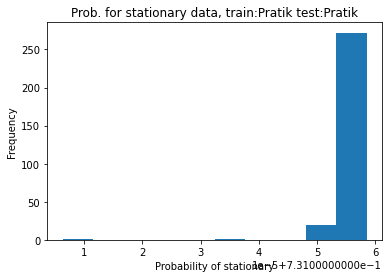

In [62]:
# Histogram of stationarity index (probability that the data is stationary), for stationary testing data. 
plt.title("Prob. for stationary data, train:" + training_label + " test:" + test_label)
plt.xlabel("Probability of stationary")
plt.ylabel("Frequency")
plt.hist(1-probnonstat_stationary)

(array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.2689414 , 0.27496502, 0.2809886 , 0.28701222, 0.2930358 ,
        0.29905942, 0.30508304, 0.31110662, 0.31713024, 0.32315382,
        0.32917744], dtype=float32),
 <BarContainer object of 10 artists>)

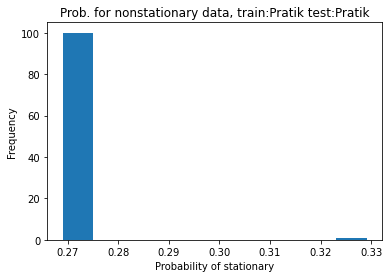

In [63]:
# Histogram of stationarity index (probability that the data is stationary), for nonstatoinary testing data. 
plt.title("Prob. for nonstationary data, train:" + training_label + " test:" + test_label)
plt.xlabel("Probability of stationary")
plt.ylabel("Frequency")
plt.hist(1-probnonstat_nonstationary)

# Outline of classification results for test data

In [64]:
# Result of correct determination
prediction_labels = tf.argmax(prediction , 1).numpy()

In [70]:
conf_matrix = tf.math.confusion_matrix(tf.convert_to_tensor(testing_y[:, 1]) , tf.convert_to_tensor(prediction_labels))
#print(conf_matrix_pratik)

# Identifying the type of error (Type I or Type II) 

true_negatives = conf_matrix[0][0].numpy()
true_positives = conf_matrix[1][1].numpy()
false_negatives = conf_matrix[1][0].numpy()
false_positives = conf_matrix[0][1].numpy()

tf.print("TN = " , true_negatives) # Negative = stationary
tf.print("TP = " , true_positives) # Positive = nonstationary
tf.print("FN = " , false_negatives)
tf.print("FP = " , false_positives)

TN =  293
TP =  101
FN =  0
FP =  0


In [71]:
correct_stationary = true_negatives / (true_negatives + false_positives)
correct_nonstationary = true_positives / (true_positives + false_negatives)
print("Number of stationary testing samples: ", true_negatives + false_positives, "; of which correct identifications:", true_negatives)
print("Correct stationary = ", correct_stationary)
print("Number of nonstationary testing samples: ", true_positives + false_negatives, "; of which correct identifications:", true_positives)
print("Correct nonstationary = ", correct_nonstationary)

Number of stationary testing samples:  293 ; of which correct identifications: 293
Correct stationary =  1.0
Number of nonstationary testing samples:  101 ; of which correct identifications: 101
Correct nonstationary =  1.0


In [46]:
# Saving names for the npz
npzfilename_stationary = "Dat_stationary_0511Pratik.npz";
npzfilename_nonstationary = "Dat_nonstationary_0511Pratik.npz";

# Valid for both stationary and nonstationary data. 
# If the range of locations are determined manually
manual_range_locs = False
# If the range of observations are determined manually
manual_range_z = False

# Folder places and filenames
# Stationary
directory_in_str_locs_stationary = "D:/Research2021-C/Pratik项目/0511Pratik_Data/subregion_stationary/"
directory_in_str_z_stationary = "D:/Research2021-C/Pratik项目/0511Pratik_Data/subregion_stationary/"
locs_string_stationary = "LOC_" # LOC_3600_sample_1.txt, LOC_3600_sample_2.txt, ...
z_string_stationary = "Z_" # Z_3600_sample_1.txt, Z_3600_sample_2.txt, ...



# Initialization 
directory_in_str_locs = directory_in_str_locs_stationary
directory_in_str_z = directory_in_str_z_stationary
locs_string = locs_string_stationary
z_string = z_string_stationary

directory_locs = os.fsencode(directory_in_str_locs)
data_folder1_locs = os.listdir(directory_locs)

location_file_list = []
Z_file_list = []
for path, subdirs, files in os.walk(directory_locs):
    for name in files:
        name_string = name.decode("utf-8")
        if name_string.startswith(locs_string): 
            location_file_path = os.path.join(path, name)
            location_file_path = location_file_path.decode("utf-8")
            z_file_path = location_file_path.replace(locs_string, z_string, 1)
            location_file_list.append(location_file_path)
            Z_file_list.append(z_file_path)

# loc_files is the file name for plotting. 
loc_files = []
for i in range(len(location_file_list)): 
    replace_res = location_file_list[i].replace(directory_in_str_locs, "")
    replace_res = replace_res.replace("\\", "_")
    loc_files.append(replace_res)

# Grid row and column
GRID_ROWS = 100
GRID_COLS = 100

# Initialization continued
ndata = len(location_file_list)
#ndata = 100 # Test
stationary_x_test = np.zeros((ndata,GRID_COLS,GRID_ROWS))

stationary_y_test = np.zeros(ndata) # Zero = the model is stationary. One = nonstationary. 

# Initialization continued
param_val_is_stat = 1;
npzfilename = npzfilename_stationary;

# Initialization continued
npzfilename = npzfilename_nonstationary;

# Initialization continued
param_is_stat = np.ones(ndata)
#param_samplenum.fill(param_val_samplenum)
param_is_stat.fill(param_val_is_stat)

param_list = []

# Main program for data preprocessing
for i_folder in tqdm(range(ndata)):
    # Append the parameter to samples. 
    param_dict = {
        "sample": i_folder,
        "is_stat": param_val_is_stat
    }
    param_list.append(param_dict)
    #==========
    # Data extraction
    #===========
    # Get location and observation files for each subsample
    loc_text = location_file_list[i_folder]
    z_text = Z_file_list[i_folder]
    # Load the location and z files
    location_file = open(loc_text)
    Z_value_file = open(z_text)
#     print(location_file)
    locations = np.loadtxt(location_file, delimiter=',')
    Z_values = np.loadtxt(Z_value_file, delimiter=',')
    #==========
    # End of data extraction
    #==========
    # Compute the output grid
    output_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_sum_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_div_arr = np.zeros((GRID_ROWS,GRID_COLS))
    if manual_range_locs == False:
        # Start and end locations (Auto)
#         print(locations[:,0],locations[:,1])
        startx = min(locations[:, 0])
        starty = min(locations[:, 1])
        endx = max(locations[:, 0])
        endy = max(locations[:, 1])
#     print(locations)
    locations[:,0] = (locations[:, 0] - startx)/(endx - startx)
    locations[:,1] = (locations[:, 1] - starty)/(endy - starty)
#     print(locations)
    
    X = np.linspace(0, 1,GRID_COLS)
    Y = np.linspace(0, 1,GRID_ROWS)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = NearestNDInterpolator(locations, Z_values)
    Z = interp(X, Y)
#     break
#     # Get the summation and division
#     for j in range(locations.shape[0]):
#         # Get the grid locations (x, y). Result: [y][x], because x is column (x=0 is the first column). 
#         x = int(math.floor((locations[j][0] - startx) * GRID_COLS / (endx - startx)))
#         y = int(math.floor((locations[j][1] - starty) * GRID_ROWS / (endy - starty)))
#         # For boundary value problems
#         x = min(x, GRID_COLS - 1)
#         y = min(y, GRID_ROWS - 1)
#         val = Z_values[j]
#         # Add the summation and division
#         grid_sum_arr[y][x] = grid_sum_arr[y][x] + val
#         grid_div_arr[y][x] += 1
#     # Generate output
#     for j1 in range(GRID_ROWS):
#         for j2 in range(GRID_COLS):
#             if grid_div_arr[j1][j2] > 0:
#                 # Mean value in a cell
#                 output_arr[j1][j2] += (grid_sum_arr[j1][j2] / grid_div_arr[j1][j2])
#             else:
#                 # Mean value over all regions if the cell has no locations
#                 output_arr[j1][j2] += np.mean(Z_values)
    if manual_range_z == False:
        # Normalize (Auto)
        m = np.min(Z)
        M = np.max(Z)
    if m == M:
        output_arr = np.ones((GRID_ROWS,GRID_COLS)) * 0.5 # All 0.5
    else: 
        # Range from 0 to 1. 
        Z = (Z - m) / (M - m)
    # Save results
    stationary_x_test[i_folder] = Z

# Load model

# Places for location saving
# model_saving_location = 'D:/Research2021-C/Pratik项目/0511Processed_Data/Model/Model_Example'

# model = Sequential()
# #add model layers
# model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(100, 100, 1)))
# model.add(Conv2D(32, kernel_size=3, activation="relu"))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(2, activation='softmax'))
# model = tf.keras.models.load_model(model_saving_location, compile = False)

# model.summary()

100%|██████████| 338/338 [00:32<00:00, 10.51it/s]


In [47]:
stationary_x_test = stationary_x_test.reshape(338,100,100,1)

In [48]:
prediction = model.predict(stationary_x_test)

In [50]:
prediction[:,1]

array([       nan,        nan, 0.9999976 , 0.9998952 , 0.99963045,
       0.9999387 , 0.99998856, 0.99981505, 0.99999666, 0.99961936,
       0.9999136 , 0.99998736, 0.9998659 , 0.99985266, 0.9999993 ,
       0.9872084 , 0.99993885, 0.99986196, 1.        , 0.99999964,
       0.99998796, 0.9999937 , 0.9999542 , 0.99993503, 0.99535334,
       0.99980897, 0.99991274, 0.99936575, 0.99999666, 0.99995005,
       0.99998677, 0.9991015 , 0.99998224, 0.9999974 , 0.9998801 ,
       0.9999864 , 0.99999785, 0.9999217 , 0.999923  , 0.9997025 ,
       0.99992895, 0.999974  , 0.99996185, 0.9980446 , 0.9402593 ,
       0.99967957, 0.9999472 , 0.9999919 , 0.9999999 , 0.9999963 ,
       0.9999995 , 0.9998266 , 0.9999957 , 0.9999846 , 0.9999652 ,
       0.9999937 , 0.99999595, 0.99966085, 0.9999999 , 0.9999999 ,
       0.9985898 , 0.99069315, 0.9998734 , 0.9999999 , 0.9999795 ,
       0.9999995 , 0.9999893 , 0.99999654, 0.9999752 , 0.99999917,
       0.9995291 , 0.9991222 , 0.9999989 , 0.99999917, 0.99849